In [1]:
import re
import string
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\X
[nltk_data]     Warrior\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\X
[nltk_data]     Warrior\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def preprocess_data(df):
    # Lowercase all text
    df['message'] = df['message'].str.lower()

    # Remove punctuation
    df['message'] = df['message'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    # Remove numbers
    df['message'] = df['message'].apply(lambda x: re.sub(r'\d+', '', x))

    # Tokenize the text
    df['message'] = df['message'].apply(lambda x: x.split())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    df['message'] = df['message'].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    df['message'] = df['message'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Join tokens back into a single string
    df['message'] = df['message'].apply(lambda x: ' '.join(x))

    # Encode labels 
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

    # Drop duplicates
    df = df.drop_duplicates()

    return df


def store_data(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.1, random_state=42)
    
    train.to_csv('train.csv', index=False)
    val.to_csv('validation.csv', index=False)
    test.to_csv('test.csv', index=False)


In [3]:
data = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=['label', 'message'])
data = preprocess_data(data)
store_data(data)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
val_data = pd.read_csv('validation.csv')

train_data = train_data.dropna()
test_data = test_data.dropna()
val_data = val_data.dropna()

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['message'])
X_val = vectorizer.transform(val_data['message'])
X_test = vectorizer.transform(test_data['message'])

y_train, y_val, y_test = train_data['label'], val_data['label'], test_data['label']


In [ ]:
#Evaluates the model
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return {
        "Precision": round(precision,3),
        "Recall": round(recall,3),
    }


: 

In [ ]:
def tune_hyperparameters(model, param_grid, X_train, y_train, X_val, y_val):
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Evaluate best model
    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)
    
    train_metrics = evaluate_model(y_train, train_preds)
    val_metrics = evaluate_model(y_val, val_preds)
    print(f'Train Metrics: {train_metrics}')
    print(f'Validation Metrics: {val_metrics}')

    df_results = pd.DataFrame({"Train": train_metrics, "Validation": val_metrics})
    df_results = df_results.reset_index().rename(columns={'index': 'Metric'})
    df_melted = df_results.melt(id_vars="Metric", var_name="Dataset", value_name="Score")

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Metric", y="Score", hue="Dataset", data=df_melted, palette="viridis")
    
    plt.title("Train vs Validation Scores")
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)  
    plt.legend(title="Dataset")
    plt.show()


In [8]:
def validate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    train_metrics = evaluate_model(y_train, train_preds)
    val_metrics = evaluate_model(y_val, val_preds)
    print(f'Train Metrics: {train_metrics}')
    print(f'Validation Metrics: {val_metrics}')

    df_results = pd.DataFrame({"Train": train_metrics, "Validation": val_metrics})
    df_results = df_results.reset_index().rename(columns={'index': 'Metric'})
    df_melted = df_results.melt(id_vars="Metric", var_name="Dataset", value_name="Score")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x="Metric", y="Score", hue="Dataset", data=df_melted, palette="viridis")
    
    plt.title("Train vs Validation Scores")
    plt.xlabel("Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)  
    plt.legend(title="Dataset")
    plt.show()

Training Logistic Regression
Train Metrics: {'Precision': np.float64(0.9798657718120806), 'Recall': np.float64(0.6854460093896714)}
Validation Metrics: {'Precision': np.float64(0.9722222222222222), 'Recall': np.float64(0.7142857142857143)}


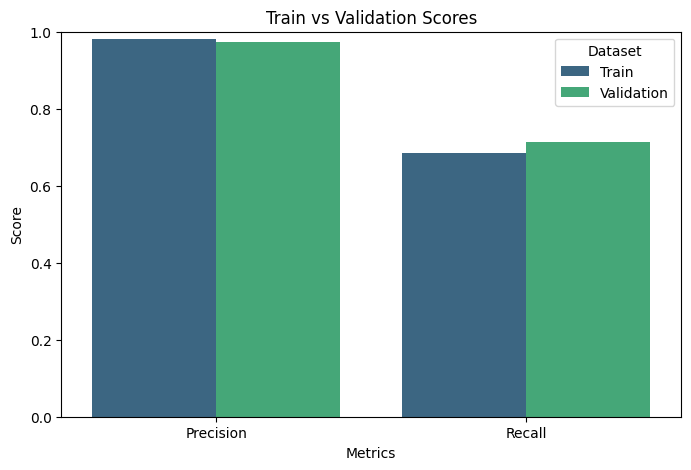

Training Random Forest
Train Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.9976525821596244)}
Validation Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.6938775510204082)}


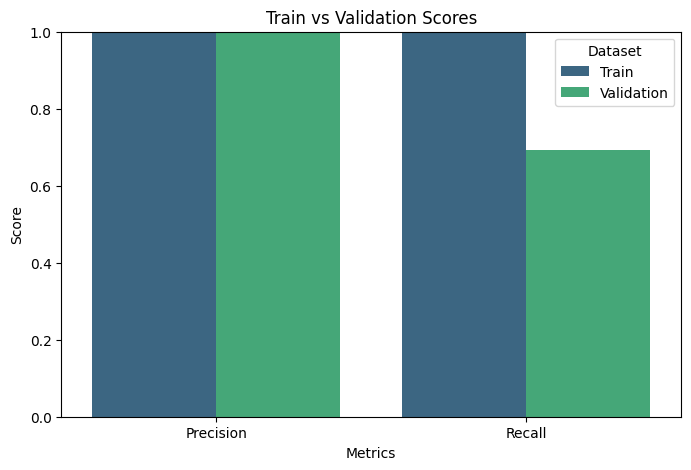

Training Naive Bayes
Train Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.7676056338028169)}
Validation Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.6326530612244898)}


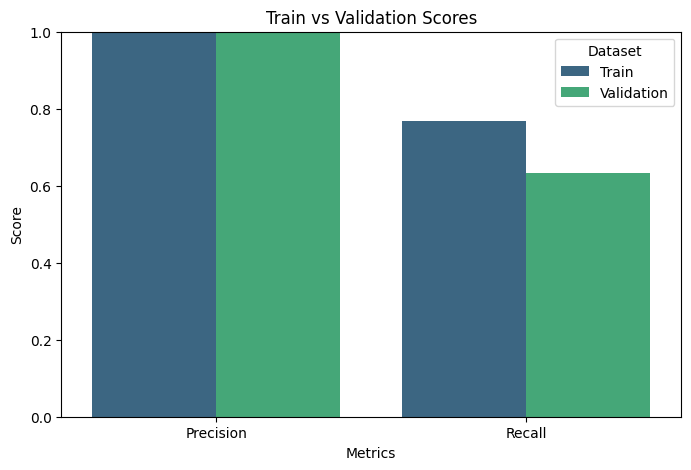

In [9]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()
}


for name, model in models.items():
    print(f"Training {name}")
    validate_model(model, X_train, y_train, X_val, y_val)

Training Logistic Regression
Train Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.9953051643192489)}
Validation Metrics: {'Precision': np.float64(0.9777777777777777), 'Recall': np.float64(0.8979591836734694)}


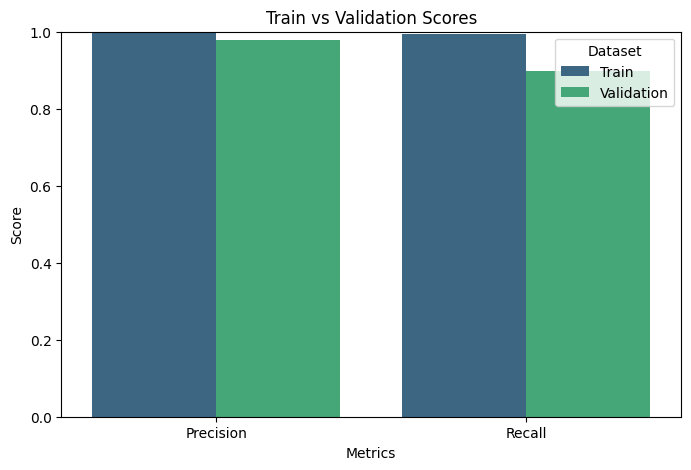

Training Random Forest


d:\Education\CMI\3rd Semester\ADA\End Sem\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Train Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.9976525821596244)}
Validation Metrics: {'Precision': np.float64(1.0), 'Recall': np.float64(0.7551020408163265)}


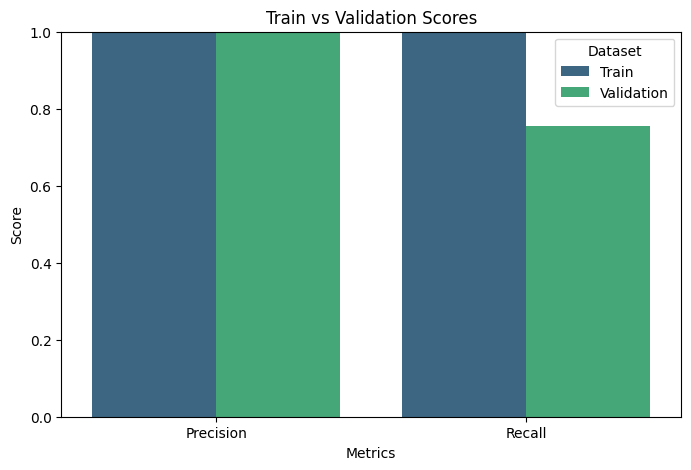

Training Naive Bayes
Train Metrics: {'Precision': np.float64(0.9927007299270073), 'Recall': np.float64(0.9577464788732394)}
Validation Metrics: {'Precision': np.float64(0.9534883720930233), 'Recall': np.float64(0.8367346938775511)}


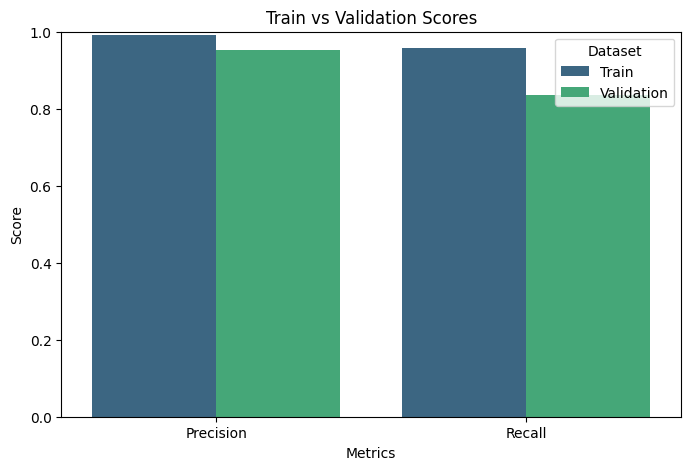

In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()
}

hyperparameters = {
    "Logistic Regression": {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2'],  
    'solver': ['liblinear', 'lbfgs']  
    },

    "Random Forest": {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
    'bootstrap': [True, False]  
    },

    "Naive Bayes": {
    'alpha': [0.01, 0.1, 1, 10],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class priors
    }
}



for name, model in models.items():
    print(f"Training {name}")
    tune_hyperparameters(model, hyperparameters[name], X_train, y_train, X_val, y_val)

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()
}

# Train, Evaluate, and Score on Test Data
benchmark_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    test_metrics = validate_model(model, X_train, y_train, X_val, y_val)
    
    benchmark_results[name] = test_metrics

# Select Best Model based on F1-score
best_model_name = max(benchmark_results, key=lambda x: benchmark_results[x]["F1 Score"])
print("Best Model:", best_model_name)
print("Benchmark Results:", benchmark_results)


Training Logistic Regression...
Training Random Forest...
Training Naive Bayes...
Best Model: Random Forest
Benchmark Results: {'Logistic Regression': {'Accuracy': 0.948768472906404, 'Precision': np.float64(0.9710144927536232), 'Recall': np.float64(0.5726495726495726), 'F1 Score': np.float64(0.7204301075268817)}, 'Random Forest': {'Accuracy': 0.9684729064039409, 'Precision': np.float64(0.967032967032967), 'Recall': np.float64(0.7521367521367521), 'F1 Score': np.float64(0.8461538461538461)}, 'Naive Bayes': {'Accuracy': 0.9625615763546798, 'Precision': np.float64(1.0), 'Recall': np.float64(0.6752136752136753), 'F1 Score': np.float64(0.8061224489795918)}}


In [14]:
train_data['label'].value_counts()

label
0    3227
1     426
Name: count, dtype: int64